In [10]:
import numpy as np
from sklearn.cluster import DBSCAN

In [11]:
# ~~ Get data ~~
from superdarn_cluster.dbtools import flatten_data_11_features, read_db
import datetime as dt

start_time = dt.datetime(2018, 2, 7)
end_time = dt.datetime(2018, 2, 8)
rad = 'sas'
db_path = "./Data/sas_GSoC_2018-02-07.db"
num_beams = 16
b = 0
data_dict = read_db(db_path, rad, start_time, end_time)
data_flat_unscaled = flatten_data_11_features(data_dict, remove_close_range=True)


In [12]:
import sklearn
sklearn.__version__

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
feature_names = ['beam', 'gate', 'vel', 'wid', 'power', 'freq', 'time', 'phi0', 'elev', 'nsky', 'nsch']

gate = data_flat_unscaled[:, 1]
power = data_flat_unscaled[:, 4]
beam = data_flat_unscaled[:, 0]
vel = data_flat_unscaled[:, 2]
wid = data_flat_unscaled[:, 3]
time_num_days = data_flat_unscaled[:, 6]

In [13]:
scaled_time = (time_num_days - time_num_days[0]) #(time - np.floor(time)) * 24 * 60 * 60
uniq_time = np.sort(np.unique(scaled_time))
shifted_time = np.roll(uniq_time, -1)
dt = np.min((shifted_time - uniq_time)[:-1])
print(dt*60*60*24)
integer_time = scaled_time / dt
scaled_time = scale(scaled_time / (dt))
# Divide by variance and center mean at 0
scaled_gate = gate
scaled_beam = beam

2.856995165348053


In [15]:
# ~~ DBSCAN ~~
# ~~ Important note: On certain systems (HDD + 8GB RAM + Ubuntu16 desktop) this won't run due to memory consumption
# ~~ Works fine on my laptop (SSD + 8GB RAM + Ubuntu18, decent i5)
time_eps = 1#400.0
beam_eps = 1#2.0
gate_eps = 1#3.0

X = np.column_stack((beam / beam_eps, gate / gate_eps)) # , integer_time / time_eps))
print(X.shape)

eps, minPts = 1, 5
db = DBSCAN(eps=eps, min_samples=minPts).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('DBSCAN clusters: %d' % n_clusters_)

(148843, 2)


DBSCAN clusters: 3


In [6]:
print(labels.shape)
print(core_samples_mask.shape)
print(X.shape)

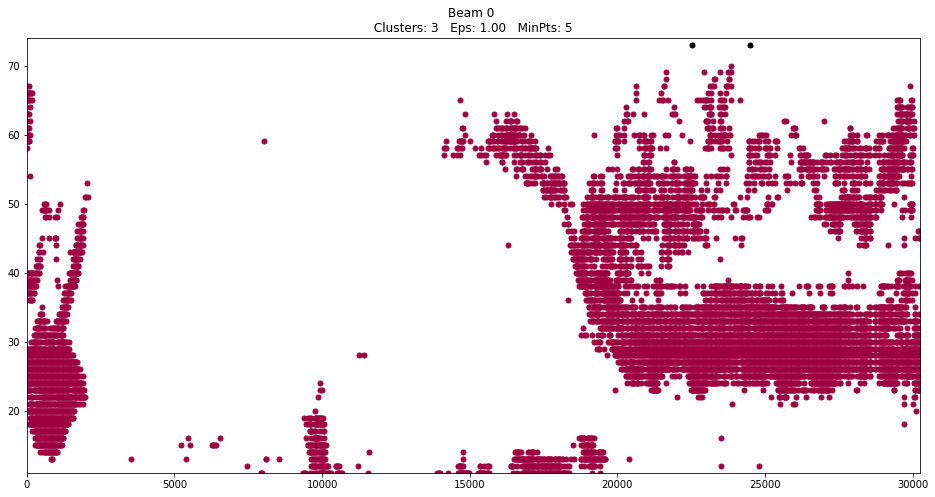

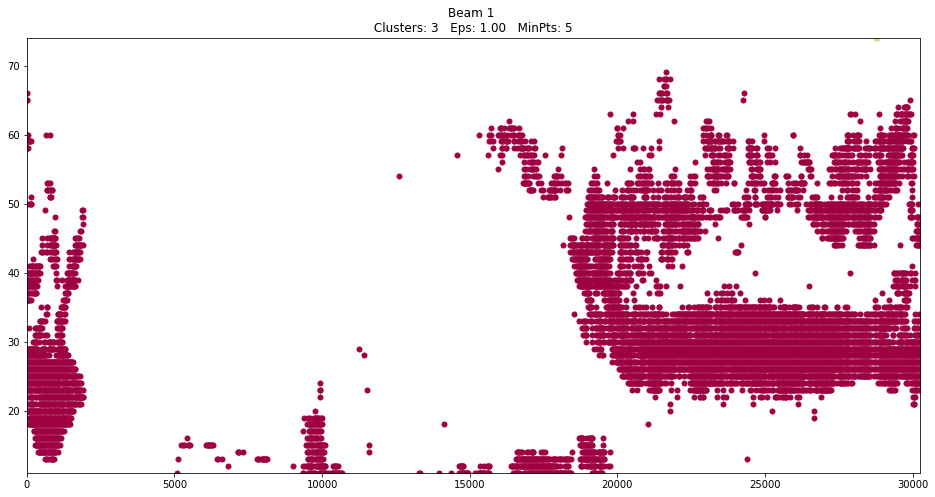

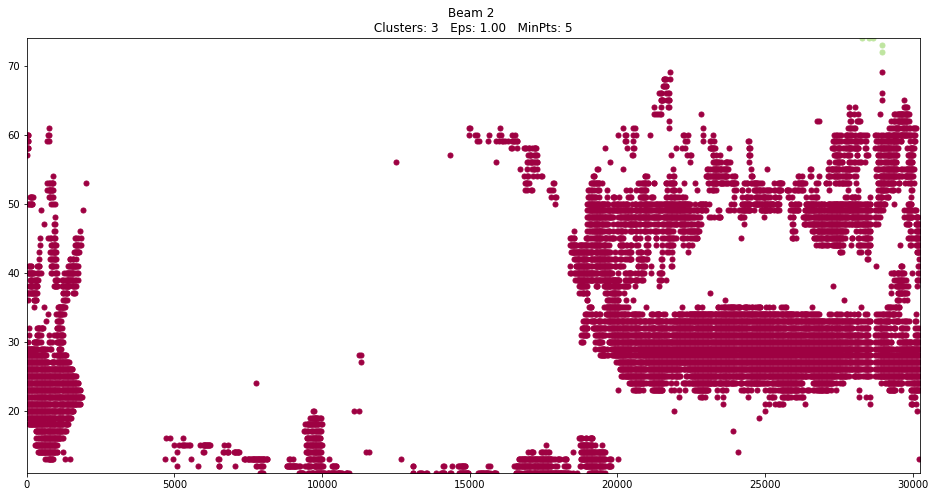

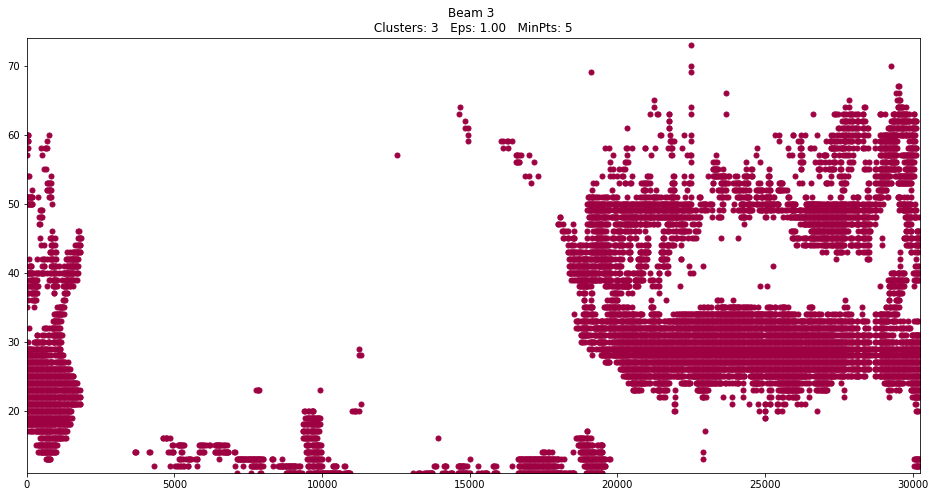

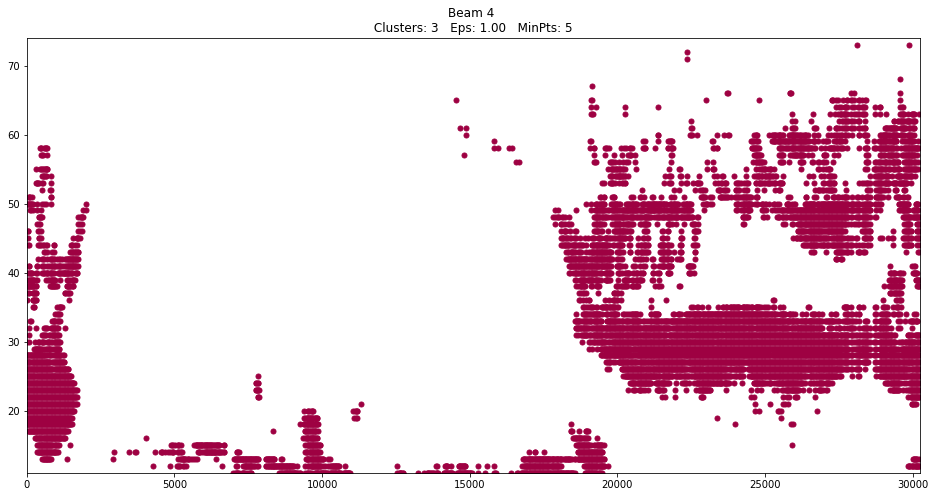

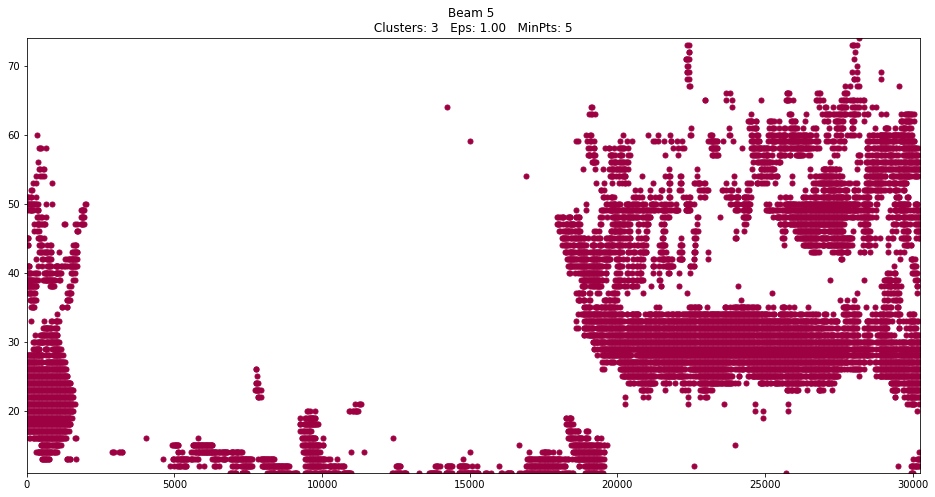

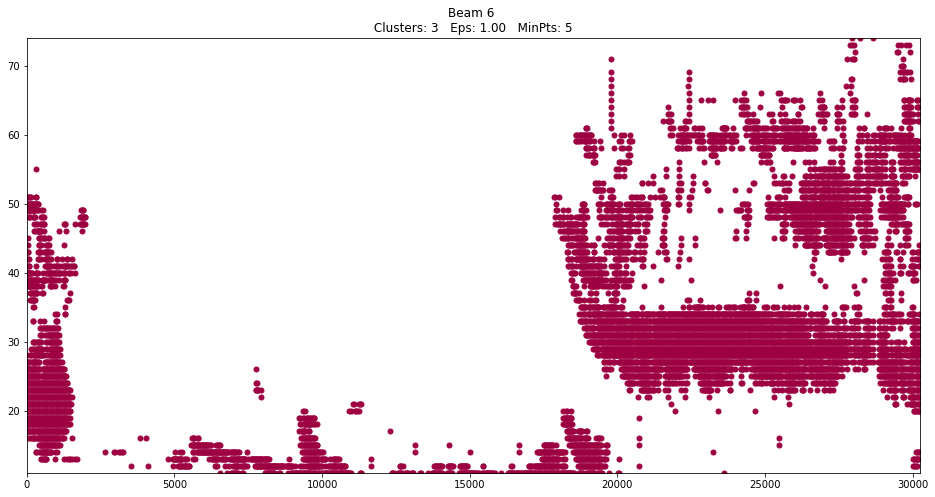

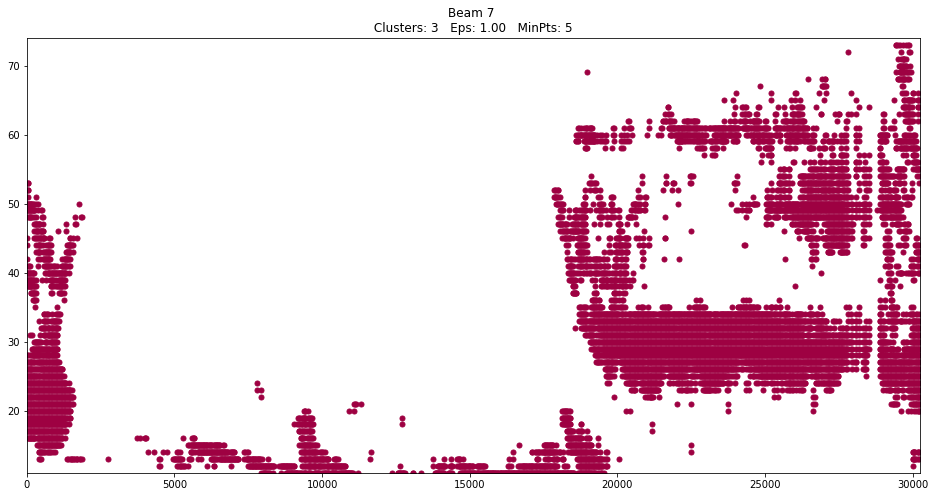

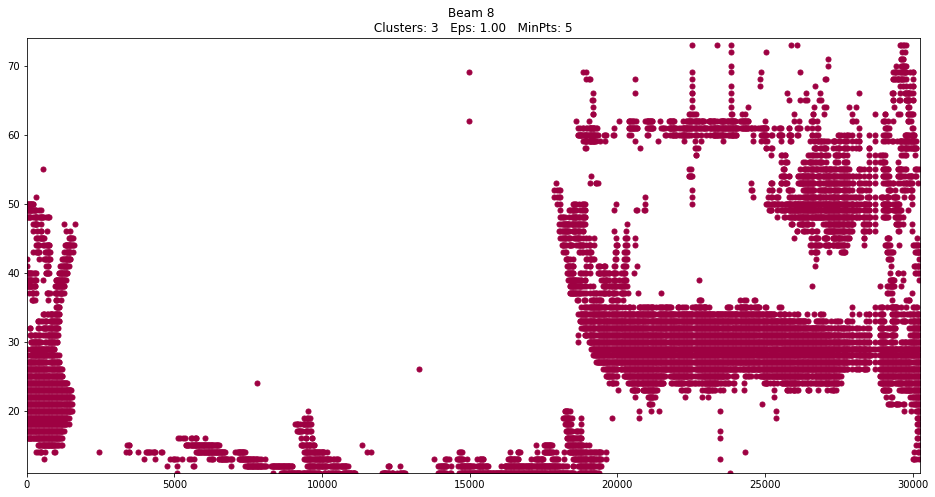

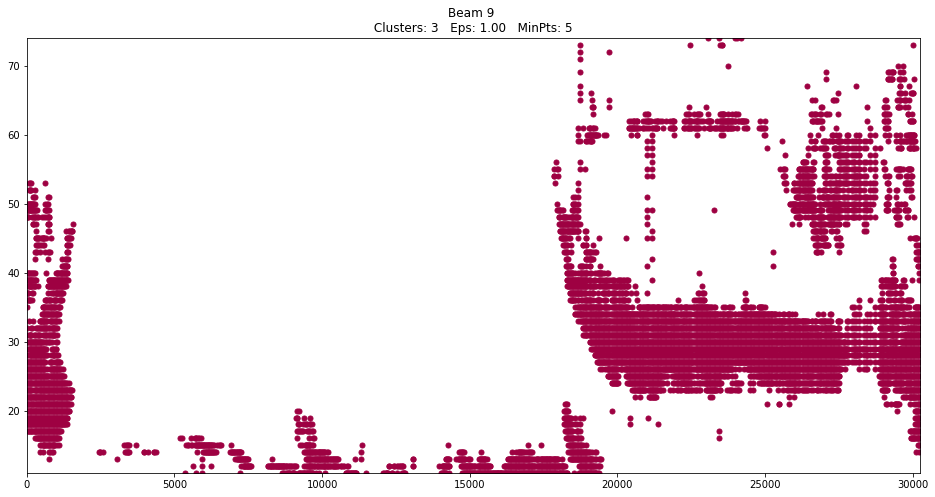

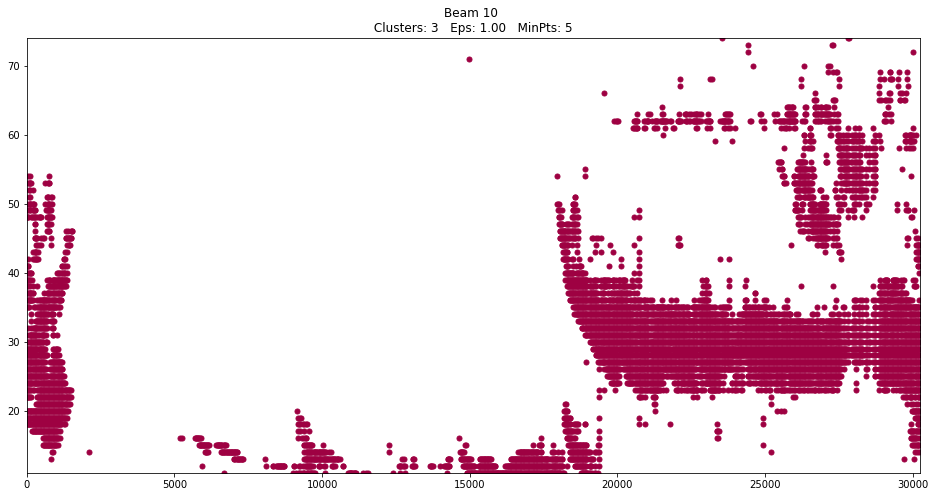

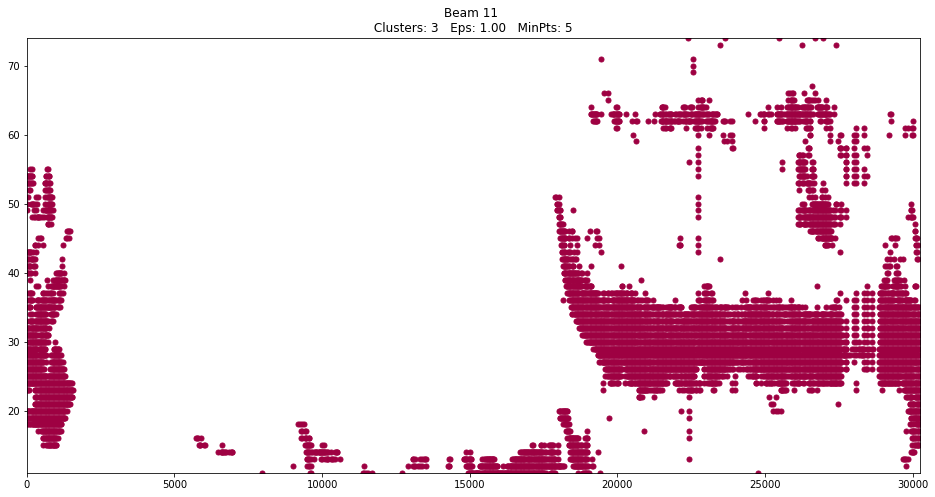

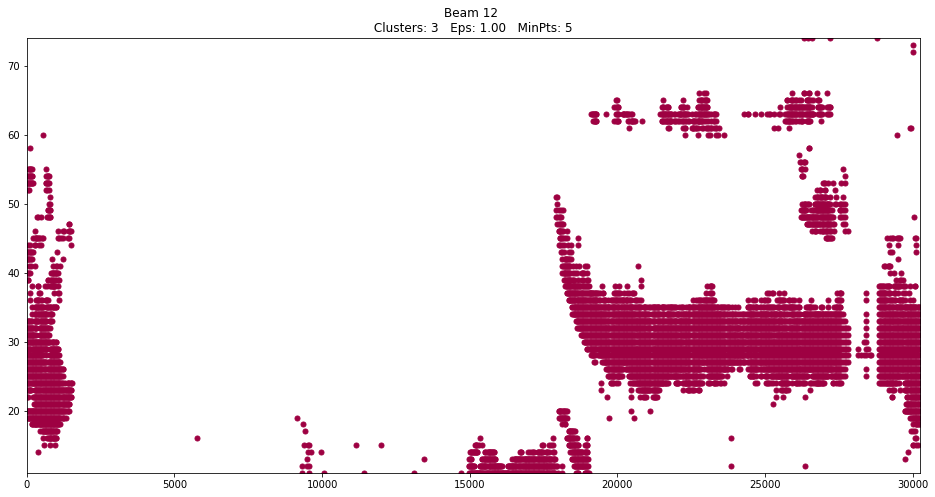

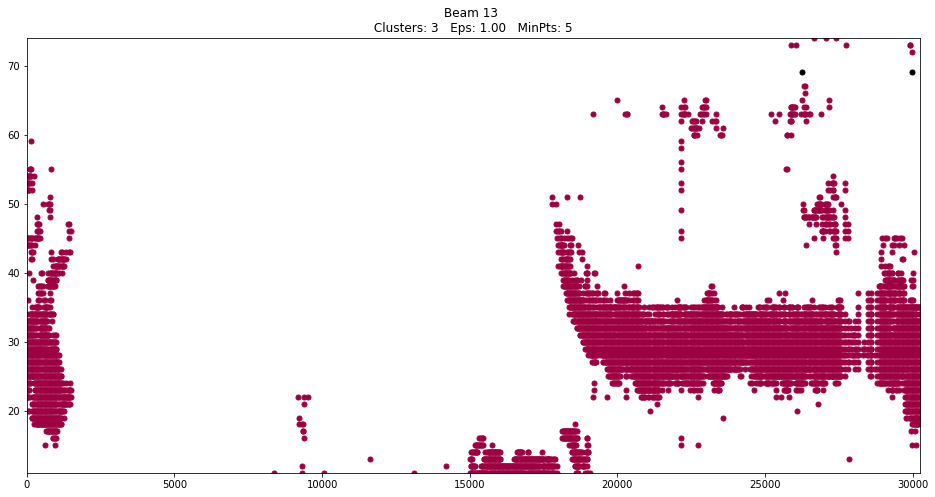

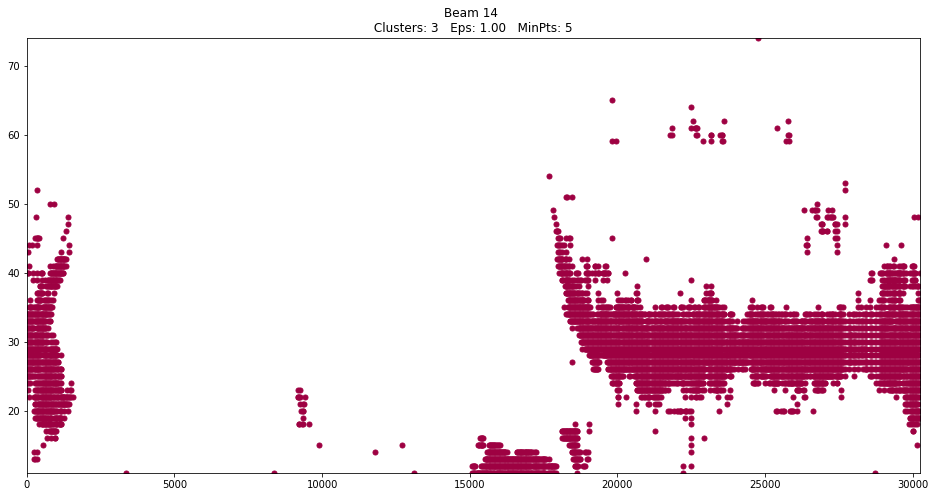

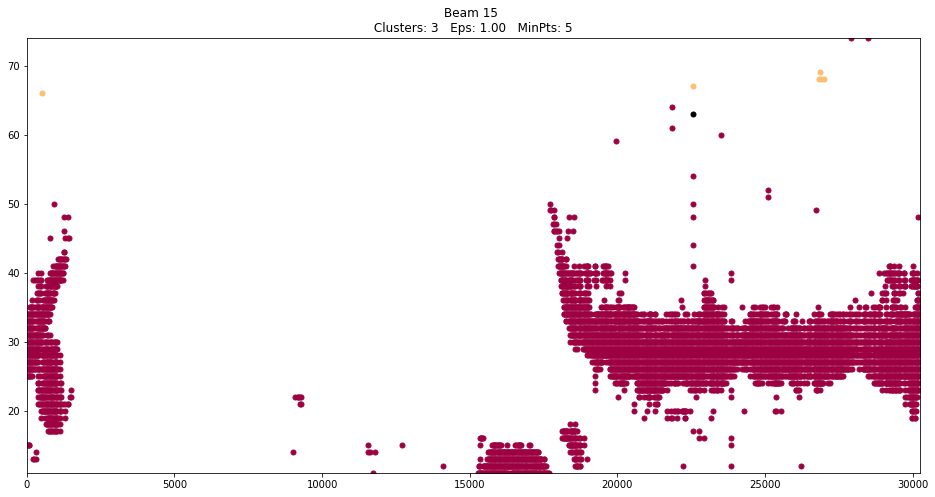

In [18]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
range_max = data_dict['nrang'][0]

from matplotlib.dates import date2num
# For each unique time unit
times_unique_dt = data_dict['datetime']
times_unique_index = np.array([date2num(d) for d in data_dict['datetime']])
from superdarn_cluster.time_utils import *
times_unique_index = time_days_to_index(times_unique_index)
index_time = time_days_to_index(time_num_days)
# ~~ Plotting all DBSCAN clusters on RTI plot (scatterplot) ~~
for b in range(num_beams):
    fig = plt.figure(figsize=(16, 8))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        beam_mask = (beam == b)

        xy = X[class_member_mask & core_samples_mask & beam_mask]
        t = integer_time[class_member_mask & core_samples_mask & beam_mask]
        plt.plot(t, xy[:, 1], '.', color=tuple(col), markersize=10)

        xy = X[class_member_mask & ~core_samples_mask & beam_mask]
        t = integer_time[class_member_mask & ~core_samples_mask & beam_mask]
        plt.plot(t, xy[:, 1], '.', color=tuple(col), markersize=10)

    plt.xlim((np.min(integer_time/time_eps), np.max(integer_time/time_eps)))
    plt.ylim((np.min(gate/gate_eps), np.max(gate/gate_eps)))
    plt.title('Beam %d \n Clusters: %d   Eps: %.2f   MinPts: %d ' % (b, n_clusters_, eps, minPts))
    plt.show()
    #plt.savefig('dbscan beam ' + str(b))
    #plt.close()


In [19]:
from superdarn_cluster.utilities import plot_clusters
stats_i = [0, 1, 2, 3, 4, 7, 8]
data_flat_unscaled[:, 2] = np.abs(data_flat_unscaled[:, 2])
data_flat_unscaled[:, 3] = np.abs(data_flat_unscaled[:, 3])
plot_clusters(labels, data_flat_unscaled[:, stats_i], data_flat_unscaled[:, 6], 
               gate, vel, np.array(feature_names)[stats_i], range_max, start_time, end_time, save=True, base_path='dbscan ')


In [8]:
# ~~ GMM ~~
from sklearn.mixture import BayesianGaussianMixture
from superdarn_cluster.utilities import plot_clusters
from scipy.stats import boxcox
# ~~ BoxCox on velocity and width
bx_vel, h_vel = boxcox(np.abs(vel))
bx_wid, h_wid = boxcox(np.abs(wid))
gmm_data = np.column_stack((bx_vel, bx_wid, time_num_days, gate, beam))

def get_gs_flg(v, w):
    med_vel = np.median(np.abs(v))
    med_wid = np.median(np.abs(w))
    #return med_vel < 33.1 + 0.139 * med_wid - 0.00133 * (med_wid ** 2)
    #return med_vel < 30 - med_wid * 1.0 / 3.0
    return med_vel < 15

stats_i = [0, 1, 2, 3, 4, 7, 8]
gs_flg = np.zeros(len(time_num_days))
for k in unique_labels:
    class_member_mask = (labels == k)
    if k == -1:
        gs_flg[class_member_mask] = -1
        continue
    k_vel = vel[class_member_mask]
    k_wid = wid[class_member_mask]
    if np.sum(class_member_mask) < 500:
        gs_flg[class_member_mask] = get_gs_flg(k_vel, k_wid)
        continue
    
    data = gmm_data[class_member_mask]
    estimator = BayesianGaussianMixture(n_components=3,
                                        covariance_type='full', max_iter=500,
                                        random_state=0, n_init=5, init_params='kmeans',
                                        weight_concentration_prior=1,
                                        weight_concentration_prior_type='dirichlet_process')
    estimator.fit(data)
    clust_labels = estimator.predict(data)
    
    class_label_i = np.where(class_member_mask)[0]
    for cl in np.unique(clust_labels):
        cluster_mask = clust_labels == cl
        #plt.scatter(data[cluster_mask, 2], data[cluster_mask, 3])
        #plt.show()
        clust_label_mask = np.zeros(len(time_num_days), dtype=bool)
        clust_label_mask[class_label_i[cluster_mask]] = True
        gs_flg[class_member_mask & clust_label_mask] = get_gs_flg(k_vel[cluster_mask], k_wid[cluster_mask])
    
    data_for_stats = data_flat_unscaled[class_member_mask]
    data_for_stats = data_for_stats[:, stats_i]
    clust_time = time_num_days[class_member_mask]
    clust_gate = gate[class_member_mask]
    clust_vel = vel[class_member_mask]
    names_for_stats = np.array(feature_names)[stats_i]
    
    plot_clusters(clust_labels, data_for_stats, clust_time, clust_gate, clust_vel, names_for_stats, range_max, start_time, end_time, 
                  save=True, base_path='gmm dbscan cluster ' + str(k) + " ")
    plt.close()

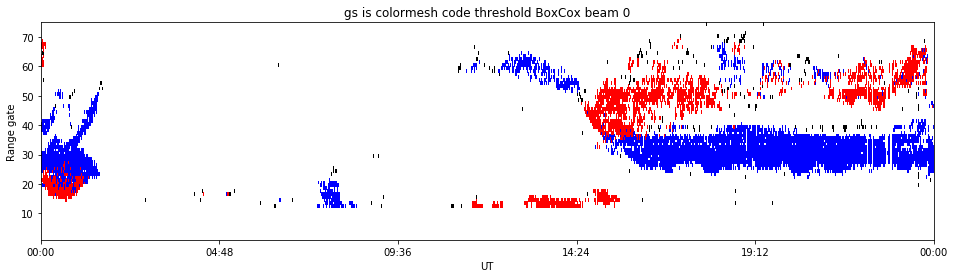

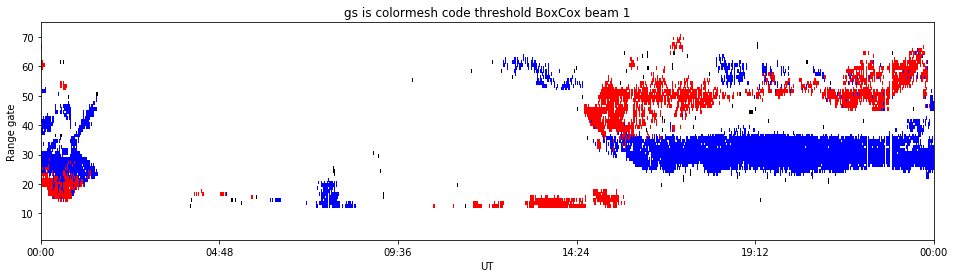

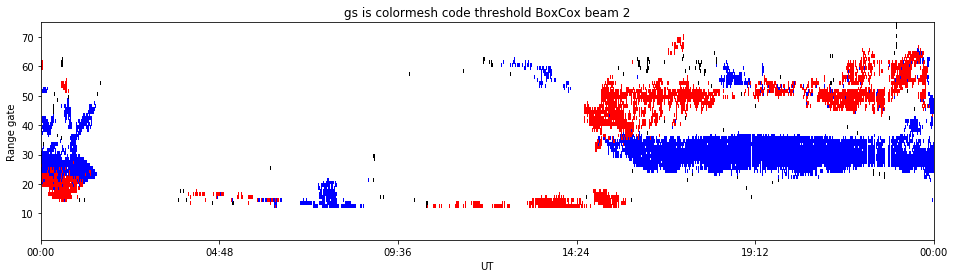

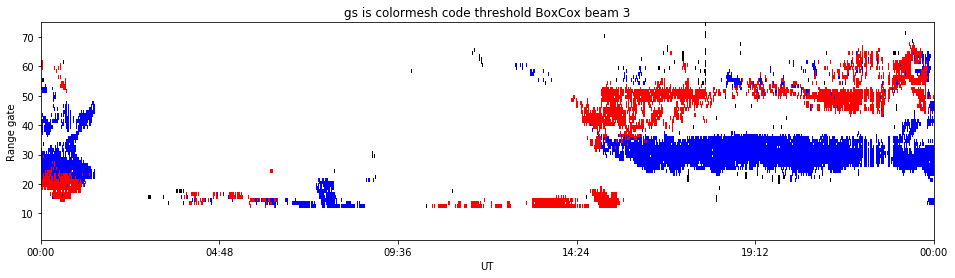

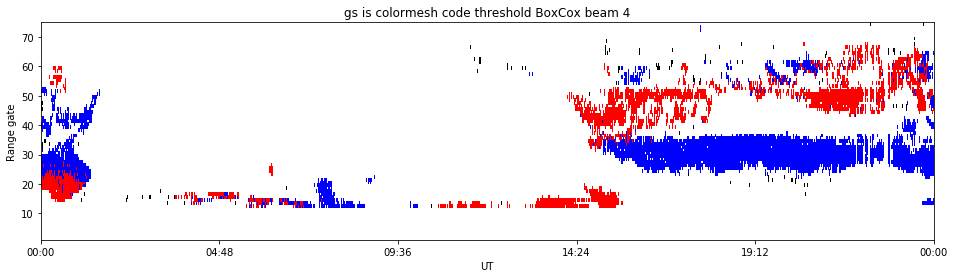

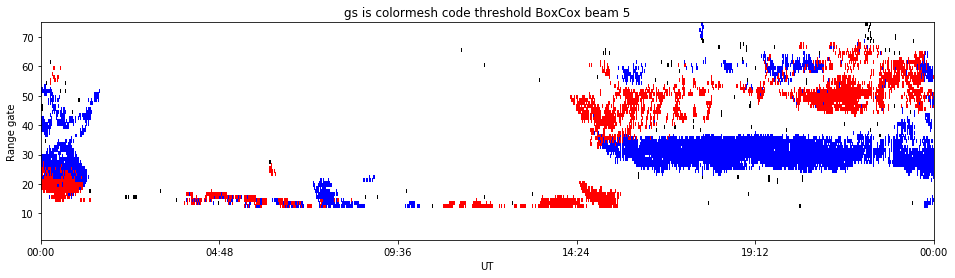

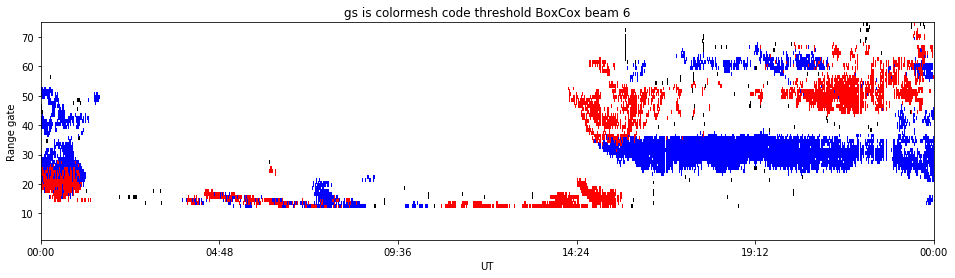

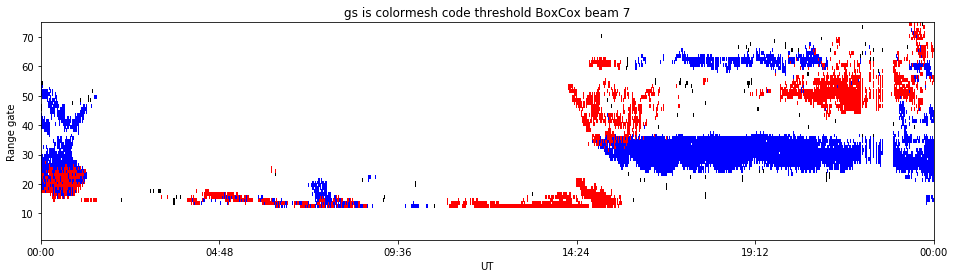

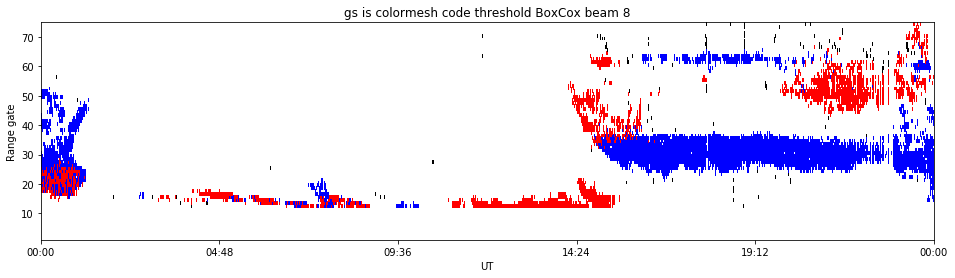

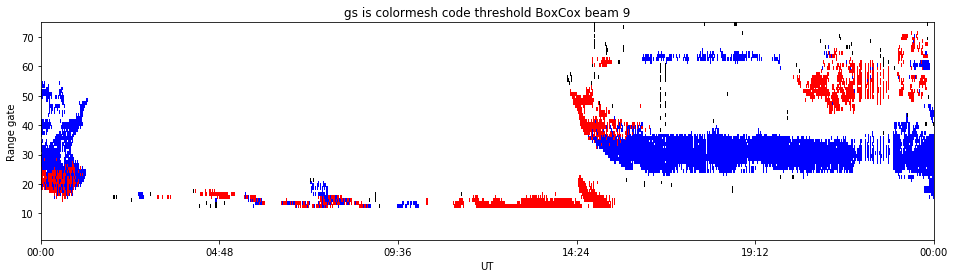

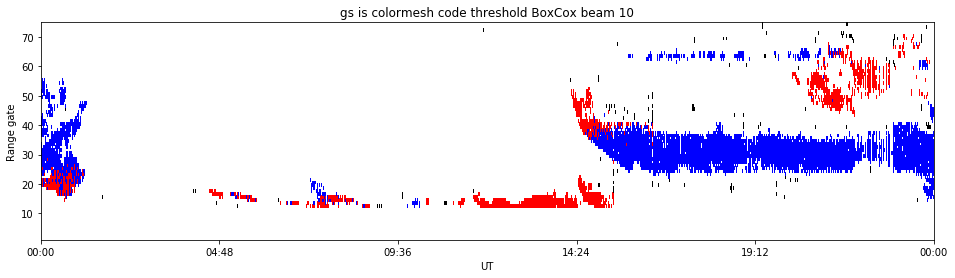

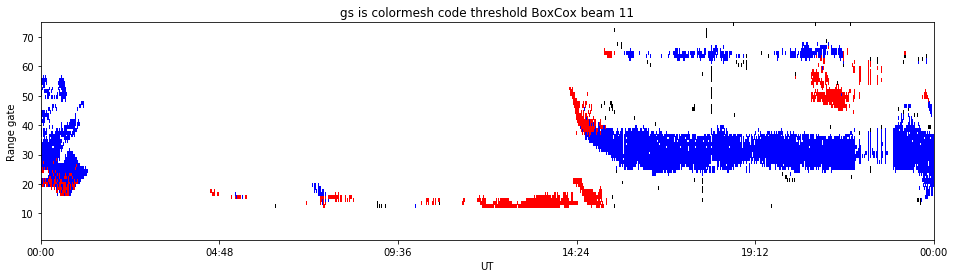

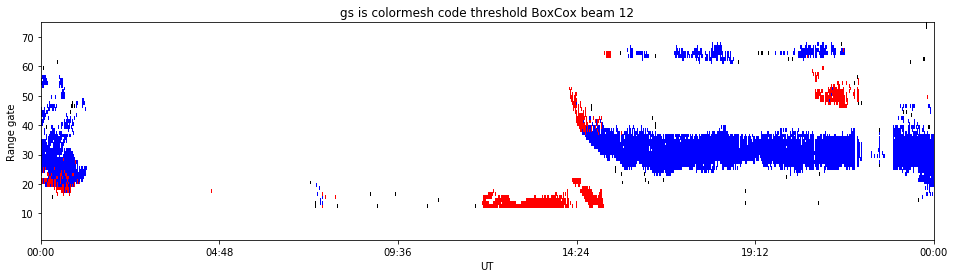

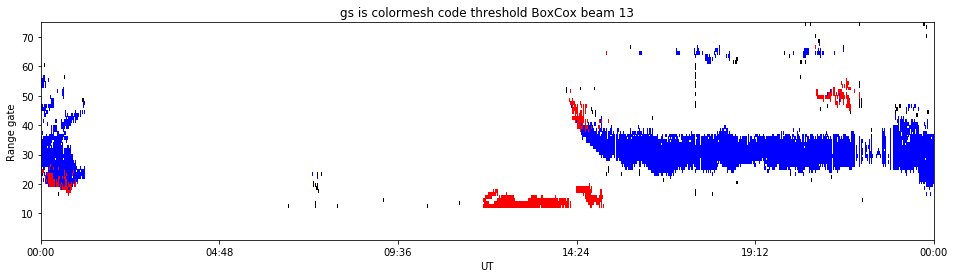

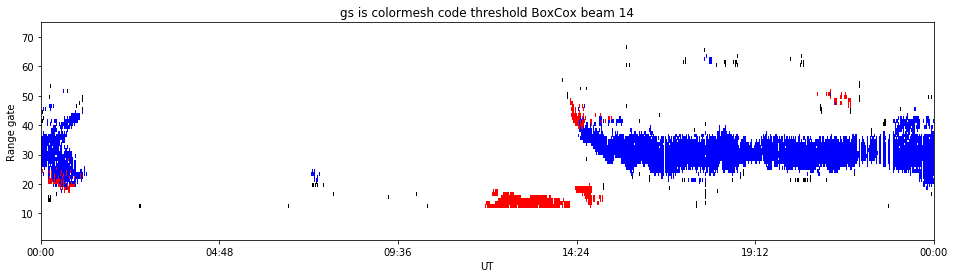

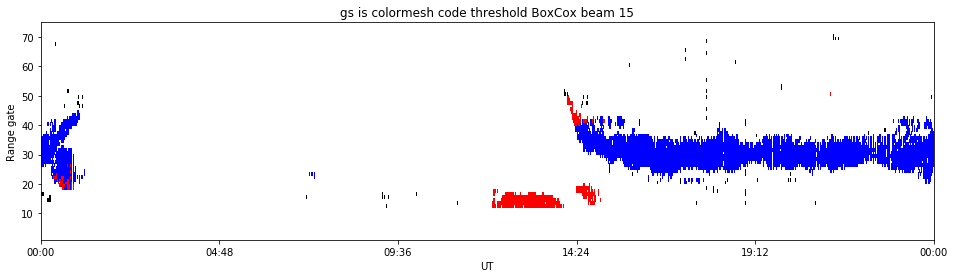

In [9]:
# ~~ IS/GS Colormesh RTI ~~
from superdarn_cluster.utilities import plot_is_gs_colormesh

#fig = plt.figure(figsize=(16, 4))
#ax = plt.subplot(111)
unique_time = [date2num(d) for d in data_dict['datetime']]

# TODO for each beam
for b in range(num_beams):
    fig = plt.figure(figsize=(16, 4))
    ax = plt.subplot(111)
    beam_filter = b == beam
    plot_is_gs_colormesh(ax, unique_time, time_num_days[beam_filter], gate[beam_filter], gs_flg[beam_filter], range_max, plot_indeterminate=True)
    plt.title('gs is colormesh code threshold BoxCox beam ' + str(b))
    plt.savefig('gs is colormesh code threshold BoxCox beam ' + str(b))